In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import requests

In [107]:
#API REQUEST TO GET POVERTY DATA 

url = "https://api.census.gov/data/timeseries/poverty/saipe"
params = {
    #SPECFIC VARIABLES OF INTEREST - Ensuring Project Relevance
    "get": "NAME,SAEMHI_PT,SAEPOV0_17_PT,SAEPOVRT0_17_PT,SAEPOVALL_PT,SAEPOVRTALL_PT,SAEPOVU_0_17,SAEPOVU_ALL,STABREV,STATE,YEAR",
    "for": "state:*",
}

response = requests.get(url, params=params)
if response.status_code == 200:
    data = response.json()
else:
    print(f"Request failed with status code {response.status_code}")

# CREATE DATA FRAME
df = pd.DataFrame(data[1:], columns=data[0]) 

In [143]:
# Making Column Names more interpretable
df = df.rename(columns={'SAEMHI_PT': 'Median_Income', 
                        'SAEPOV0_17_PT': 'Child_Poverty_Count',
                        'SAEPOVRT0_17_PT': 'Child_Poverty_Rate',
                        'SAEPOVALL_PT': 'Poverty_Count',
                        'SAEPOVRTALL_PT': 'Poverty_Rate',
                        'SAEPOVU_0_17': 'All_Child_Poverty_Count',
                        'SAEPOVU_ALL': 'All_Poverty_Count'})

# Drop redundant Columns
df = df.drop(columns = [ 'state' ])


# Convert Columns to proper data type
exclude_columns = ['NAME', 'STABREV']
columns_to_convert = [col for col in df.columns if col not in exclude_columns]
df[columns_to_convert] = df[columns_to_convert].apply(pd.to_numeric, errors='coerce', downcast='integer')
 
# Filter for relevant years
years_of_interest = [2013, 2014, 2015, 2018, 2019, 2020, 2023]
df = df[df['YEAR'].isin(years_of_interest)]

#Exaimining Data Types
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 357 entries, 1020 to 1580
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   NAME                     357 non-null    object 
 1   Median_Income            357 non-null    int32  
 2   Child_Poverty_Count      357 non-null    int32  
 3   Child_Poverty_Rate       357 non-null    float64
 4   Poverty_Count            357 non-null    int32  
 5   Poverty_Rate             357 non-null    float64
 6   All_Child_Poverty_Count  357 non-null    int32  
 7   All_Poverty_Count        357 non-null    int32  
 8   STABREV                  357 non-null    object 
 9   STATE                    357 non-null    int8   
 10  YEAR                     357 non-null    int16  
dtypes: float64(2), int16(1), int32(5), int8(1), object(2)
memory usage: 22.0+ KB


In [124]:
#Exaimine NA Values
df.isna().sum().sum()

#Resolved

np.int64(0)

In [151]:
#Summary Statistics
df.describe()

,Median_Income,Child_Poverty_Count,Child_Poverty_Rate,Poverty_Count,Poverty_Rate,All_Child_Poverty_Count,All_Poverty_Count,STATE,YEAR
count,357.000000,3.570000e+02,357.000000,3.570000e+02,357.000000,3.570000e+02,3.570000e+02,357.000000,357.000000
mean,62332.963585,2.644844e+05,17.775350,8.505579e+05,13.305042,1.411678e+06,6.219694e+06,28.960784,2017.428571
std,13156.595147,3.342090e+05,5.164769,1.018352e+06,3.130491,1.635515e+06,7.060394e+06,15.698838,3.336649
min,38191.000000,1.106100e+04,7.500000,5.241800e+04,7.000000,1.096300e+05,5.633450e+05,1.000000,2013.000000
25%,51914.000000,5.594900e+04,13.600000,1.976260e+05,10.800000,3.702580e+05,1.734091e+06,16.000000,2014.000000
50%,60794.000000,1.759950e+05,17.400000,5.850970e+05,12.800000,9.882870e+05,4.326301e+06,29.000000,2018.000000
75%,70939.000000,3.006490e+05,21.300000,9.287780e+05,15.600000,1.610783e+06,7.259760e+06,42.000000,2020.000000
max,104643.000000,2.119056e+06,34.000000,6.328064e+06,23.900000,9.030489e+06,3.881853e+07,56.000000,2023.000000


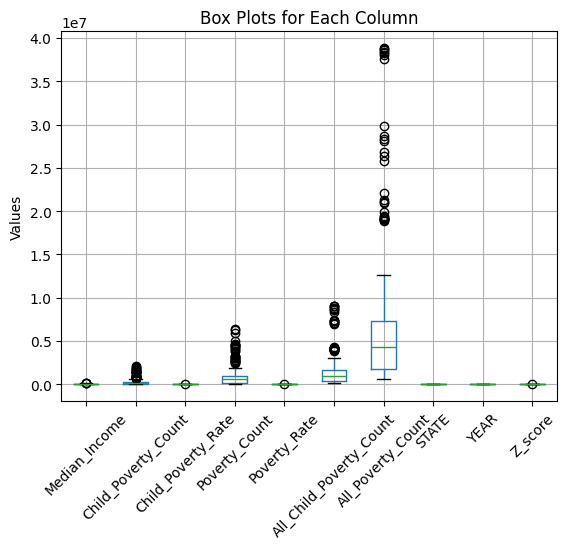

In [165]:
# Quick look for Outliers - Should make pretty if we want to post

df.boxplot()
plt.title('Box Plots for Each Column')
plt.ylabel('Values')
plt.xticks(rotation = 45)
plt.show()

In [166]:
#Exaiming Poverty Rate Outliers

#Based upon Z-score
df['Z_score'] = (df['Poverty_Rate'] - df['Poverty_Rate'].mean()) / df['Poverty_Rate'].std()
outliers_z = df[np.abs(df['Z_score']) > 2]
outliers_z

#Given the lack of any overly extreme values, all rates appear legitamate

,NAME,Median_Income,Child_Poverty_Count,Child_Poverty_Rate,Poverty_Count,Poverty_Rate,All_Child_Poverty_Count,All_Poverty_Count,STABREV,STATE,YEAR,Z_score
1038,Louisiana,44234,311059,28.4,897284,20.0,1097099,4494987,LA,22,2013,2.138629
1044,Mississippi,38191,246458,34.0,692058,23.9,725052,2893762,MS,28,2013,3.384440
1051,New Mexico,44026,151127,30.1,437923,21.4,502248,2045405,NM,35,2013,2.585843
1089,Louisiana,44680,307469,28.0,898902,19.9,1097124,4518537,LA,22,2014,2.106685
1095,Mississippi,39738,220885,30.7,634960,21.9,719646,2895486,MS,28,2014,2.745562
1102,New Mexico,44905,138918,28.0,420388,20.6,496465,2045506,NM,35,2014,2.330292
1146,Mississippi,40630,225347,31.5,638919,22.1,715914,2896612,MS,28,2015,2.809450
1153,New Mexico,45524,133471,27.2,405364,19.8,490693,2044455,NM,35,2015,2.074741
1299,Mississippi,44740,195794,28.2,571402,19.8,694588,2886375,MS,28,2018,2.074741
1406,New Hampshire,81415,20726,8.4,92404,7.0,247828,1325241,NH,33,2020,-2.014074


In [ ]:
df.to_csv("Poverty_Clean.csv", index=False)